# Get Edge

In [1]:
!pwd

/nfs/Workspace/TeethSeg/exps


In [2]:
%reload_ext autoreload

In [3]:
# !pip install SimpleITK
# !pip install cython

# !conda install pytorch

# Install pycocotools, 
# the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [4]:
import numpy as np
from numpy.lib.function_base import append
import os

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

from PIL import Image, ImageDraw, ImageFont

import SimpleITK as sitk

from tqdm import tqdm

import cv2 as cv

In [5]:
root_dir = '/nfs/Workspace/dataset/teeth/data50'

img_dir = os.path.join(root_dir, 'image')
mask_dir = os.path.join(root_dir, 'label')

save_dir = os.path.join(root_dir, 'edge')
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

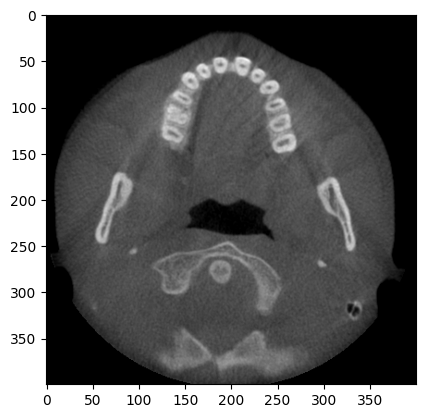

In [6]:
img = sitk.ReadImage(os.path.join(img_dir, '1000813648_20180116.nii.gz'))
img = sitk.GetArrayFromImage(img)

plt.imshow(img[140,:,:], cmap='gray')

2
[0 1]


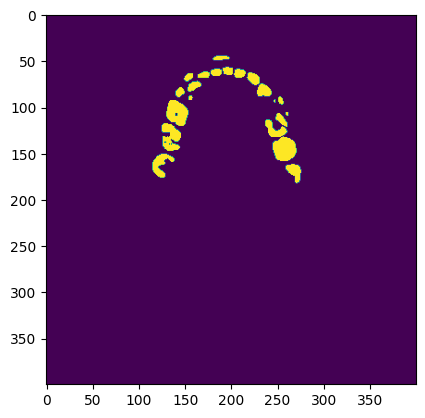

In [7]:
masks = sitk.ReadImage(os.path.join(mask_dir, '1000813648_20180116.nii.gz'))
masks = sitk.GetArrayFromImage(masks).astype(np.uint8)
masks[masks>0] = 1
plt.imshow(masks[120,:,:])
print(len(np.unique(masks)))
print(np.unique(masks))

In [8]:
# kernel = np.ones((3,3),np.uint8)

# mask = masks.copy()

# plt.figure(dpi=200)
# plt.subplot(141)
# plt.imshow(mask[120,:,:])

# plt.subplot(142)
# dil = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations = 1)
# plt.imshow(dil[120,:,:])

# plt.subplot(143)
# dil2 = cv.dilate(mask, kernel, iterations=2)
# plt.imshow(dil2[120,:,:])

# plt.subplot(144)
# ed = cv.subtract(dil2, dil)
# plt.imshow(ed[120,:,:])

In [9]:
mask_names = list(sorted([_ for _ in os.listdir(mask_dir) if _.endswith('.nii.gz')]))
print(len(mask_names))
print(mask_names)

53
['1000813648_20180116.nii.gz', '1000889125_20171009.nii.gz', '1000889125_20171016.nii.gz', '1000889125_20180109.nii.gz', '1000889125_20180521.nii.gz', '1000889125_20181106.nii.gz', '1000889125_20190408.nii.gz', '1000889125_20191101.nii.gz', '1000889125_20200421.nii.gz', '1000915187_20180115.nii.gz', '1000915187_20191217.nii.gz', '1000966359_20180113.nii.gz', '1000971031_20180112.nii.gz', '1000983254_20180109.nii.gz', '1000983254_20180904.nii.gz', '1000995722_20180112.nii.gz', '1001009635_20180116.nii.gz', '1001012179_20180116.nii.gz', '1001020384_20180114.nii.gz', '1001022839_20180110.nii.gz', '1001022839_20180225.nii.gz', '1001028863_20180115.nii.gz', '1001068663_20180116.nii.gz', '1001111103_20180114.nii.gz', '1001127112_20180109.nii.gz', '1001133637_20180110.nii.gz', '1001142392_20180110.nii.gz', '1001142392_20180116.nii.gz', '1001142392_20180511.nii.gz', '1001152328_20150714.nii.gz', '1001152328_20180112.nii.gz', '1001152328_20180306.nii.gz', '1001152328_20180910.nii.gz', '10011

In [10]:
for data in tqdm(mask_names[:]):
    data_path = os.path.join(mask_dir, data)
    
    data_nii = sitk.ReadImage(data_path)
    masks = sitk.GetArrayFromImage(data_nii).astype(np.uint8)
    masks[masks>0] = 1

    edge_arr = np.zeros_like(masks)
    kernel = np.ones((2,2),np.uint8)
    for i in range(edge_arr.shape[0]):
        edge_arr[i] = cv.Canny(masks[i], 1, 2)
    edge_arr = cv.dilate(edge_arr, kernel, iterations=1)
    
    edge_img = sitk.GetImageFromArray(edge_arr)
    
    edge_img.SetOrigin(data_nii.GetOrigin())
    edge_img.SetDirection(data_nii.GetDirection())
    edge_img.SetSpacing(data_nii.GetSpacing())

    save_path = os.path.join(save_dir, data)
    sitk.WriteImage(edge_img, save_path)
    
    print(save_path)

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

/nfs/Workspace/dataset/teeth/data50/edge_test/1000813648_20180116.nii.gz


## show edgemap

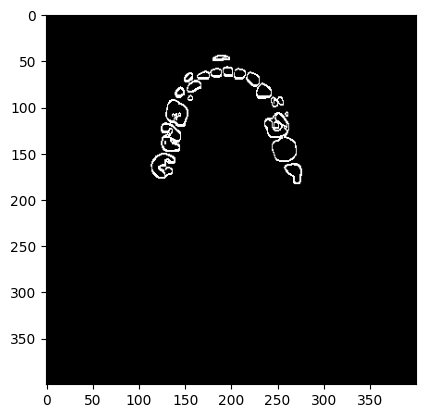

In [11]:
masks = sitk.ReadImage(os.path.join(save_dir, '1000813648_20180116.nii.gz'))
masks = sitk.GetArrayFromImage(masks).astype(np.uint8)

plt.imshow(masks[120,:,:], cmap='gray')

In [12]:
%%shell

# download the Penn-Fudan dataset
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
# unzip PennFudanPed.zip

UsageError: Cell magic `%%shell` not found.


Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

Instance Segmentation

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    # global dataset_mask_path

    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list([_ for _ in os.listdir(os.path.join(root,'PNGImages')) if _.endswith('.png')])
        self.masks = list(sorted([_ for _ in os.listdir(os.path.join(root,'GrayMasks')) if _.endswith('.png')]))
        self.imgs = sorted(self.imgs, key=lambda s:nfs.get_nums(s))
        self.masks = sorted(self.masks, key=lambda s:nfs.get_nums(s))
        
    def __getitem__(self, idx):       
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        graymask_path = os.path.join(self.root, "GrayMasks", self.masks[idx])
        # print(img_path)

        img = Image.open(img_path).convert("RGB")

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(graymask_path)        
        mask = np.array(mask)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # idx_list = []
        # idx_list = [i for i, _ in enumerate(obj_ids, 1)]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            
            if xmin < xmax and ymin < ymax:
                boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        if(boxes.shape[0]==0):
            area = torch.tensor([0])
        else:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["img_path"] = img_path
        target["graymask_path"] = graymask_path
        
        # use PennFudanDataset('ToothDataset/train', get_transform(train=False))
        #                                           -----------------------------
        # let type(img) : <class 'PIL.Image.Image'> -> <class 'torch.Tensor'>
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

    def __len__(self):
        return len(self.imgs)

EdgeMaps

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    # global dataset_mask_path

    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list([_ for _ in os.listdir(os.path.join(root,'PNGImages')) if _.endswith('.png')])
        self.masks = list(sorted([_ for _ in os.listdir(os.path.join(root,'EdgeMaps')) if _.endswith('.png')]))
        self.imgs = sorted(self.imgs, key=lambda s:nfs.get_nums(s))
        self.masks = sorted(self.masks, key=lambda s:nfs.get_nums(s))
        
    def __getitem__(self, idx):       
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        graymask_path = os.path.join(self.root, "EdgeMaps", self.masks[idx])
        # print(img_path)

        img = Image.open(img_path).convert("RGB")

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(graymask_path)        
        mask = np.array(mask)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # idx_list = []
        # idx_list = [i for i, _ in enumerate(obj_ids, 1)]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            
            if xmin < xmax and ymin < ymax:
                boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        if(boxes.shape[0]==0):
            area = torch.tensor([0])
        else:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["img_path"] = img_path
        target["graymask_path"] = graymask_path
        
        # use PennFudanDataset('ToothDataset/train', get_transform(train=False))
        #                                           -----------------------------
        # let type(img) : <class 'PIL.Image.Image'> -> <class 'torch.Tensor'>
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [ ]:
dataset = PennFudanDataset('ToothDataset/train')
# dataset = PennFudanDataset('ToothDataset/test/1001152328_20150714')
img_slices, target_slices = dataset[150]
masks = target_slices['masks']

plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(img_slices, cmap='gray')
plt.subplot(122)
plt.imshow(masks[2,:,:], cmap='gray')

In [ ]:
def drawLine(im, boxes):
    im = Image.fromarray(np.uint8(im))
    image = im.copy()

    draw = ImageDraw.Draw(image) #實例化一個對象
    rows = boxes.shape[0]
    cols = boxes.shape[1]

    for i in range(rows):
        # [xmin, ymin, xmax, ymax]
        xmin = boxes[i][0].item()
        ymin = boxes[i][1].item()
        xmax = boxes[i][2].item()
        ymax = boxes[i][3].item()

        # draw.line((100,200, 150, 300), fill=128, width=3)
        draw.line((xmin, ymin, xmax, ymin), fill="red", width=1)  #line start and end coord, line width
        draw.line((xmax, ymin, xmax, ymax), fill="red", width=1)
        draw.line((xmax, ymax, xmin, ymax), fill="red", width=1)
        draw.line((xmin, ymax, xmin, ymin), fill="red", width=1)

    return image

In [ ]:
#draw boxes
dataset_idx = 120

test_data = dataset[dataset_idx][1]
image_id = test_data['image_id'].item()

img_path = test_data['img_path']
mask_path = test_data['graymask_path']
boxes = test_data['boxes']

print('img_path = ', img_path)
print('mask_path = ', mask_path)

masks = sitk.ReadImage(mask_path)
masks = sitk.LabelToRGB(masks)
masks = sitk.GetArrayViewFromImage(masks).astype(np.int8)

draw = drawLine(masks, boxes)
draw

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) #True False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [ ]:
# %%shell

# # Download TorchVision repo to use some files from
# # references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout -f v0.8.2

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False) #True
# dataset = PennFudanDataset('ToothDataset', get_transform(train=False)) #True
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True, num_workers=4,
#     collate_fn=utils.collate_fn
# )
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('ToothDataset/train', get_transform(train=True)) #True
eval_dataset = PennFudanDataset('ToothDataset/train', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[:-50]) #indices[:-50]
eval_dataset = torch.utils.data.Subset(eval_dataset, indices[-50:]) #indices[-50:]

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

eval_data_loader = torch.utils.data.DataLoader(
    eval_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
print(len(data_loader))
print(len(eval_data_loader))

### Now let's instantiate the model and the optimizerdataset_test

In [ ]:
!pwd

In [ ]:
# instance seg
pretrained_model_pth = os.path.join("/home/cg/maskrcnn2d/ToothDataset", "best_metric_model_SGD_360.pth")

# edge maps
# pretrained_model_pth = os.path.join("/home/cg/maskrcnn2d/ToothDataset", "best_metric_model_edgemaps.pth")

print(pretrained_model_pth)
# pretrained_model_pth = os.path.join("/content/drive/Shareddrives/Tooth/Pytorch_MaskRCNN/ToothDataset", "best_metric_model_usePreTrain.pth")

#### First train

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.001) #lr=0.0001 0000025 -> Bad result
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

#### load pretrained model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.0001) #lr=0.0001 0000025

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#------------------------------------------

checkpoint = torch.load(pretrained_model_pth)      
model.load_state_dict(checkpoint['state_dict']) # , strict=False
model.to(device)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
print(f'load pretrained model: {pretrained_model_pth}')

#------------------------------------------

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
from engine import train_one_epoch, evaluate

from torch.optim.lr_scheduler import StepLR
num_epochs = 1000 #1000

best_iou_metric_sum = -1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    coco_evaluator = evaluate(model, eval_data_loader, device=device)

    print('cur_iou_metric', coco_evaluator.coco_eval['segm'].stats)
    iou_metrics  = len(coco_evaluator.coco_eval['segm'].stats)
    cur_iou_metric_sum = sum(coco_evaluator.coco_eval['segm'].stats)/iou_metrics
    print('best_iou_metric_sum:', best_iou_metric_sum)
    print('cur_iou_metric_sum:', cur_iou_metric_sum)

    if cur_iou_metric_sum > best_iou_metric_sum:
        print('model save...')
        best_iou_metric_sum = cur_iou_metric_sum
        
        # torch.save(model.state_dict(), pretrained_model_pth)
        torch.save({'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),    # HERE IS THE CHANGE
                    }, pretrained_model_pth)

In [ ]:
coco_evaluator.coco_eval['segm'].stats

In [ ]:
step = optimizer.state[optimizer.param_groups[0]["params"][-1]]["step"]

In [ ]:
test_id = '1001152328_20150714'
dataset_path = os.path.join('ToothDataset/test/', test_id)

show origin mask

In [ ]:
# show origin mask
mask_path = f'ToothDataset/cbcts/test/label/{test_id}.nii.gz'

msks = sitk.ReadImage(mask_path) # h, w, c (y, x, z)
msks = sitk.GetArrayFromImage(msks).astype(np.uint8)

print(f'ori mask lbl = {np.unique(msks)}, \nlen = {len(np.unique(msks))}')

msk = msks[116,:,:]
plt.imshow(msk)

print(f'\nthis mask lbl = {np.unique(msk)}, \nlen = {len(np.unique(msk))}')

testing one data

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
test_dataset = PennFudanDataset(dataset_path)
test_img, test_info = test_dataset[0]
plt.imshow(test_img)

In [ ]:
# pick one image from the test set
test_dataset = PennFudanDataset(dataset_path, get_transform(train=False))
test_img, test_info = test_dataset[150]
test_img_numpy = test_img.mul(255).permute(1, 2, 0).byte().numpy()

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([test_img.to(device)])

In [ ]:
print(f"pred mask: {prediction[0]['masks'].shape}")
print(f"pred mask score: {prediction[0]['scores']}")

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [ ]:
Image.fromarray(test_img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

#### concatenate all pred_mask to nii.gz

Get Sematic Segmentation Result

Masks

In [ ]:
# concatenate all pred_mask to nii.gz

def get_sematic_res(test_id):
    # test_id = '1001162439_20150708'
    test_path = os.path.join('ToothDataset/test/', test_id)
    print('get sematic, file path :', test_path)
    
    test_dataset = PennFudanDataset(test_path, get_transform(train=False))

    slice_num = len(test_dataset)
    print('slice_num :', slice_num)

    pred_cbct = None
    for slice_idx in tqdm(range(slice_num)):
        test_img, test_info = test_dataset[slice_idx]

        # put the model in evaluation mode
        model.eval()
        with torch.no_grad():
            prediction = model([test_img.to(device)])

        pred_score = prediction[0]['scores'].cpu().numpy()
        pred_mask = prediction[0]['masks'].cpu().numpy()
        pred_mask_num = pred_mask.shape[0]
        # print('pred_masks shape :', pred_mask.shape)
        # print('pred_scores :', pred_score)
        # print('')

        new_mask = np.zeros((pred_mask.shape[-2], pred_mask.shape[-1]))

        for mask_idx in range(pred_mask_num):
            if pred_score[mask_idx] > 0.8:
                new_mask = new_mask + pred_mask[mask_idx, 0, :, :]

        # thresholding
        thresholding_val = 0.6
        new_mask[new_mask < thresholding_val] = 0
        new_mask[new_mask >= thresholding_val] = 1    
        # print(np.unique(new_mask))

        new_mask = new_mask[np.newaxis] 

        if np.any(pred_cbct==None):
            pred_cbct = new_mask
        else:
            pred_cbct = np.concatenate((pred_cbct, new_mask), axis=0)

    pred_cbct = pred_cbct.astype('uint8')
    print('pred_cbct :', pred_cbct.shape)

    # out = sitk.GetImageFromArray(pred_cbct)
    # out_name = '{}/pred_sematic_{}.nii.gz'.format(test_path, test_id)
    # sitk.WriteImage(out, out_name)
    # print('! save ', out_name)
    
    return pred_cbct

Edge Maps

In [ ]:
# concatenate all pred_mask to nii.gz

def get_sematic_edge_res(test_id):
    # test_id = '1001162439_20150708'
    test_path = os.path.join('ToothDataset/test/', test_id)
    print('get sematic, file path :', test_path)
    
    test_dataset = PennFudanDataset(test_path, get_transform(train=False))

    slice_num = len(test_dataset)
    print('slice_num :', slice_num)

    pred_cbct = None
    for slice_idx in tqdm(range(slice_num)):
        test_img, test_info = test_dataset[slice_idx]

        # put the model in evaluation mode
        model.eval()
        with torch.no_grad():
            prediction = model([test_img.to(device)])

        pred_score = prediction[0]['scores'].cpu().numpy()
        pred_mask = prediction[0]['masks'].cpu().numpy()
        pred_mask_num = pred_mask.shape[0]
        # print('pred_masks shape :', pred_mask.shape)
        # print('pred_scores :', pred_score)
        # print('')

        new_mask = np.zeros((pred_mask.shape[-2], pred_mask.shape[-1]))

        for mask_idx in range(pred_mask_num):
            if pred_score[mask_idx] > 0.8:
                new_mask = new_mask + pred_mask[mask_idx, 0, :, :]

        # thresholding
        thresholding_val = 0.1
        new_mask[new_mask < thresholding_val] = 0
        new_mask[new_mask >= thresholding_val] = 1    
        # print(np.unique(new_mask))

        new_mask = new_mask[np.newaxis] 

        if np.any(pred_cbct==None):
            pred_cbct = new_mask
        else:
            pred_cbct = np.concatenate((pred_cbct, new_mask), axis=0)

    pred_cbct = pred_cbct.astype('uint8')
    print('pred_cbct :', pred_cbct.shape)

    # out = sitk.GetImageFromArray(pred_cbct)
    # out_name = '{}/pred_sematic_{}.nii.gz'.format(test_path, test_id)
    # sitk.WriteImage(out, out_name)
    # print('! save ', out_name)
    
    return pred_cbct

Get Instance Segmentation Result

In [ ]:
def instance_preprocessing(test_id):
    # preprocessing
    # only remain mask with pred_mask score > 0.8
    # make pixel values > 0.6 become 1
    
    # test_id = '1001162439_20150708'    
    test_path = os.path.join('ToothDataset/test/', test_id)

    print('Instance preprocessing...')
    print('Only remain mask with pred_mask score > 0.8 and make pixel values > 0.6 become 1.\n')
    
    test_dataset = PennFudanDataset(test_path, get_transform(train=False))

    slice_num = len(test_dataset)
    print('slice_num :', slice_num)

    new_slices = []

    for slice_idx in tqdm(range(slice_num)):
        img, info = test_dataset[slice_idx]

        model.eval()
        with torch.no_grad():
            pred = model([img.to(device)])

        pred_score = pred[0]['scores'].cpu().numpy()
        pred_mask = pred[0]['masks'].cpu().numpy()
        pred_mask_num = pred_mask.shape[0]

        # only remain mask with pred_mask score > 0.8
        new_masks = None
        for mask_idx in range(pred_mask_num):
            new_mask = pred_mask[mask_idx, 0, :, :]

            if pred_score[mask_idx] >= 0.9:
                # make pixel values <= 0.5 ecome 0
                new_mask[new_mask <= 0.6] = 0
                new_mask[new_mask > 0.6] = 1
                new_mask = new_mask[np.newaxis]

                if np.all(new_masks == None):
                    new_masks = new_mask
                else:
                    new_masks = np.concatenate((new_masks, new_mask), axis=0)

        # if no pred_mask score > 0.8 or no mask 
        if np.all(new_masks == None):
            new_masks = np.zeros((pred_mask.shape[-2], pred_mask.shape[-1]))[np.newaxis]

        new_slices.append(new_masks)

    print(f'len(new_slices) = {len(new_slices)}')
    
    return new_slices

In [ ]:
def set_new_label(new_slices, test_id):
    slice_num = len(new_slices)
    print('set_new_label...')
    print(f'for loop num = slice_num -1 ({slice_num-1})')
    
    test_path = os.path.join('ToothDataset/test/', test_id)
    
    out_res = None
    pre_slice02 = None
    max_lbl = 1 # start with 1 (max_lbl + 1)
    had_lbl = False
    min_iou = 999

                          #range(120,123)
    for slice_idx in tqdm(range(slice_num-1)):
        # print(f'slice_idx = {slice_idx}')

        if np.all(pre_slice02 == None):
            slice01 = new_slices[slice_idx].astype('uint8')
            slice02 = new_slices[slice_idx+1].astype('uint8')
            pre_slice02 = slice02
        else:
            slice01 = pre_slice02
            slice02 = new_slices[slice_idx+1].astype('uint8')
            pre_slice02 = slice02

        # print(np.unique(slice01))
        # print(np.unique(slice02))

        # print(slice01.shape)
        # print(slice02.shape)
        mask01_num = slice01.shape[0]
        mask02_num = slice02.shape[0]

        res = np.zeros((slice01.shape[-2], slice01.shape[-1]))
        # assert -1>0

        for m01_idx in range(mask01_num):
            mask01 = slice01[m01_idx, :, :]

            # mask had label
            mask01_max_lbl = np.max(mask01)

            if mask01_max_lbl == 1:
                had_lbl = False
            elif mask01_max_lbl > 1:
                had_lbl = True
            else:
                # all black(0)
                break

            find = False

            for m02_idx in range(mask02_num):
                mask02 = slice02[m02_idx, :, :] 

                # get iou
                intersection = mask01 * mask02
                intersection[intersection>1] = 1
                intersection = np.sum(intersection)      
                union = mask01 + mask02
                union[union>1] = 1
                union = np.sum(union)
                iou = intersection/union

                if iou < min_iou:
                    min_iou = iou

                if iou >= 0.3:
                    find = True

                    if not had_lbl:
                        color_lbl = max_lbl + 1
                        max_lbl = color_lbl # update
                        res[mask01==1] = color_lbl
                        mask02[mask02==1] = color_lbl
                    else:
                        color_lbl = mask01_max_lbl
                        res[mask01==mask01_max_lbl] = color_lbl
                        mask02[mask02==1] = color_lbl

                    # print(f'mask01 idx:{m01_idx} paired with mask02 idx:{m02_idx}, iou: {iou}')
                    # print(f'mask01 max val: {np.max(mask01)}, color label: {np.max(mask02)}\n')

                    # plt.subplot(1,3,1)
                    # plt.imshow(mask01)
                    # plt.subplot(1,3,2)
                    # plt.imshow(mask02)

            if not find:
                if not had_lbl:
                    color_lbl = max_lbl + 1
                    max_lbl = color_lbl # update

                    res[mask01==1] = color_lbl
                    # print(f'add new color_lbl = {color_lbl}')
                else:
                    color_lbl = mask01_max_lbl
                    res[mask01==mask01_max_lbl] = color_lbl   

        # print('max_lbl = ', max_lbl)
        # print('')

        res = res[np.newaxis]
        if np.all(out_res == None):
            out_res = res
        else:
            out_res = np.concatenate((out_res, res), axis=0)

    print(f'min_iou = {min_iou}')        
    print(f'out_res.shape = {out_res.shape}')
    print(f'np.unique(out_res): {np.unique(out_res)}')
    
    out = sitk.GetImageFromArray(out_res)
    out_name = '{}/pred_instance_{}.nii.gz'.format(test_path, test_id)
    sitk.WriteImage(out, out_name)
    print('! save ', out_name)

    return out_res

In [ ]:
def get_instance_res(test_id):
    test_path = os.path.join('ToothDataset/test/', test_id)
    print(f'file path : {test_path}')
    
    new_slices = instance_preprocessing(test_id)
    out_res = set_new_label(new_slices, test_id)
    
    return out_res

In [ ]:
test_path = os.path.join('ToothDataset/test/')
test_name = list(sorted([_ for _ in os.listdir(test_path) if not _.endswith('.ipynb_checkpoints')]))
test_name

<span style="color:blue">get sematic result</span>

In [ ]:
test_id

In [ ]:
pred_cbct = get_sematic_res(test_id)

plt.figure(dpi=150)
plt.imshow(pred_cbct[0,:,:])

In [ ]:
plt.figure(dpi=300)
plt.imshow(pred_cbct[150,:,:], cmap='gray')

edge

In [ ]:
pred_edge = get_sematic_edge_res(test_id)

In [ ]:
plt.figure(dpi=300)
plt.imshow(pred_edge[110,:,:], cmap='gray')

<span style="color:blue">get instance res</span>

In [ ]:
out_res = get_instance_res('1001162439_20150708')

In [ ]:
out_res = get_instance_res('1001162439_20140520')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,dpi = 800)

slice_idx = 120
for i, ax in enumerate(axes.flat, start=1):
    m = my_res[slice_idx+i,:,:]
    uni_m = np.unique(m)
    print(f'unique = {len(uni_m)}')
    print(uni_m)
    ax.set_title('Test Axes {}'.format(i), size = 5)
    ax.imshow(m)

fig.tight_layout()
plt.show()

#### Get Dice Score

In [ ]:
test_path = os.path.join('ToothDataset/test/')
test_name = list(sorted([_ for _ in os.listdir(test_path) if not _.endswith('.ipynb_checkpoints')]))
test_name

In [ ]:
pred_cbct = get_sematic_res('1001152328_20150sl714')

Masks

In [ ]:
test_id

In [ ]:
# get origin mask
ori_mask_path = os.path.join('ToothDataset/test/', test_id, 'GrayMasks')

slices_path = list([_ for _ in os.listdir(ori_mask_path) if _.endswith('.png')])
slices_path = sorted(slices_path, key=lambda s:nfs.get_nums(s))
print(len(slices_path))
ori_masks = None
for p in tqdm(slices_path):
    ori_mask = Image.open(os.path.join(ori_mask_path, p))        
    ori_mask = np.array(ori_mask)
    ori_mask[ori_mask>0] = 1   
    ori_mask = ori_mask[np.newaxis]
    
    if np.any(ori_masks==None):
        ori_masks = ori_mask
    else:
        ori_masks = np.concatenate((ori_masks, ori_mask), axis=0)
        
print(ori_masks.shape)

In [ ]:
plt.imshow(ori_masks[100,:,:])

In [ ]:
plt.imshow(pred_cbct[100,:,:])

EdgeMaps

In [ ]:
# get origin edge maps
ori_mask_path = os.path.join('ToothDataset/test/', test_id, 'EdgeMaps')

slices_path = list([_ for _ in os.listdir(ori_mask_path) if _.endswith('.png')])
slices_path = sorted(slices_path, key=lambda s:nfs.get_nums(s))
print(len(slices_path))
ori_masks = None
for p in tqdm(slices_path):
    ori_mask = Image.open(os.path.join(ori_mask_path, p))        
    ori_mask = np.array(ori_mask)
    ori_mask[ori_mask>0] = 1   
    ori_mask = ori_mask[np.newaxis]
    
    if np.any(ori_masks==None):
        ori_masks = ori_mask
    else:
        ori_masks = np.concatenate((ori_masks, ori_mask), axis=0)
        
print(ori_masks.shape)

In [ ]:
plt.imshow(ori_masks[100,:,:], cmap='gray')
print(np.unique(ori_masks))

In [ ]:
plt.imshow(pred_edge[100,:,:], cmap='gray')
print(np.unique(pred_edge))

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [ ]:
def dice_average_sets(y_true, y_pred):
    assert y_true.shape[0]==y_pred.shape[0], "you should use same size data"
    dice = []
    for i in range(y_true.shape[0]):
        dice.append(dice_coef(y_true[i], y_pred[i]))
    print(np.mean(dice))
    return dice

In [ ]:
dice = dice_average_sets(ori_masks, pred_cbct)

In [ ]:
dice = dice_average_sets(ori_masks, pred_edge)

Show pred masks and boxes

In [ ]:
def write_pred_label_mask(image, label, pred, file_name):
    '''
    output red color is predict mask,
    green color is gt mask,
    yellow color is the intersection of prediction mask and gt mask
    '''
    image = np.array(image)
    image = Image.fromarray(image).convert('L')
    pred = np.array(pred)
    pred[pred<240] = 0 # thresholding, can avoid black border

    label = np.array(label)
    # image = image.astype(np.uint8)

    pred = pred / 255.
    label = label / 255.
    
    pred_mask = (image * pred).astype(np.uint8)   
    label_mask = (image * label).astype(np.uint8)
    union_mask = (image * np.logical_or(pred_mask, label_mask)).astype(np.uint8)
    no_mask = image - union_mask

    r = no_mask + label_mask
    g = no_mask + pred_mask
    b = no_mask

    rgb_img = np.stack([r, g, b], -1)
    rgb_img = Image.fromarray(rgb_img)

    return rgb_img
    # rgb_img.save(file_name)

In [ ]:
# def check_intersection(ans, pred):
#   inter = False

#   ans0_sum = np.sum(ans==0)
#   pred0_sum = np.sum(pred==0)
#   diff = pred - ans
#   diff0_sum = np.sum(diff==0)
#   print(ans0_sum, pred0_sum, diff0_sum)
#   if diff0_sum > pred0_sum:
#     inter = True
#     print(True)
#   return inter

In [ ]:
def show_pred_img(img, ans_mask, ans_boxes, pred_mask, pred_boxes): 
    ans_mask_num = ans_mask.shape[0]
    pred_mask_num = pred_mask.shape[0]

    ans_line_im = drawLine(img, ans_boxes)
    pred_line_im = drawLine(img, pred_boxes)

    plt.figure('test', (30, 20), dpi=200)

    #----------------------------------------------------------------------------
    plt.subplot(4,1,1)
    plt.title("image")
    plt.imshow(test_img_numpy, cmap='gray')

    #----------------------------------------------------------------------------
    plt.subplot(4,1,2)
    plt.title("image & label\n masks =" + str(ans_mask_num))
    plt.imshow(test_img_numpy, cmap='gray')
    # plt.imshow(ans_line_im, cmap='gray')
    for i in range(ans_mask_num):
        mask = ans_mask[i].mul(255).byte().cpu().numpy()
        mask = np.where(mask != 0, i + 1, mask)
        lbl_mask = np.ma.masked_where(mask == 0, mask)
        plt.imshow(lbl_mask, alpha=1.0, vmin = 1, vmax = ans_mask_num)

  #----------------------------------------------------------------------------
    plt.subplot(4,1,3)
    plt.title("pred image & label\n masks =" + str(pred_mask_num))
    plt.imshow(test_img_numpy, cmap='gray')
    # plt.imshow(pred_line_im, cmap='gray')

    for i in range(pred_mask_num):
        mask = pred_mask[i, 0].mul(255).byte().cpu().numpy()
        mask = np.where(mask != 0, i + 1, mask)
        lbl_mask = np.ma.masked_where(mask == 0, mask)
        plt.imshow(lbl_mask, alpha=1.0, vmin = 1, vmax = pred_mask_num)

  #----------------------------------------------------------------------------
    plt.subplot(4,1,4)
    plt.title("label & pred image\n")
    # plt.imshow(pred_line_im, cmap='gray')

    # (0, 11), (3, 1),
    ans_mask = ans_mask[3].mul(255).byte().cpu().numpy()
    pred_mask = pred_mask[1, 0].mul(255).byte().cpu().numpy()

    rgb_img = write_pred_label_mask(test_img_numpy, ans_mask, pred_mask, 'test') 
    plt.imshow(rgb_img)

    # plt.savefig('pred.png', dpi=100)
    plt.show()

In [ ]:
img = Image.fromarray(test_img_numpy)
ans_boxes = test_info['boxes']
ans_mask = test_info['masks']
pred_boxes = prediction[0]['boxes']
pred_mask = prediction[0]['masks']

show_pred_img(img, ans_mask, ans_boxes, pred_mask, pred_boxes)

In [ ]:
# def show_intersec_img(img, ans_mask, ans_boxes, pred_mask, pred_boxes): 
plt.rcParams['figure.dpi'] = 300

ans_mask_num = ans_mask.shape[0]
pred_mask_num = pred_mask.shape[0]

ans_line_im = drawLine(img, ans_boxes)
pred_line_im = drawLine(img, pred_boxes)

# (0, 11), (3, 1)
mask = ans_mask[13].mul(255).byte().cpu().numpy()      
mask02 = pred_mask[12, 0].mul(255).byte().cpu().numpy()
rgb_img = write_pred_label_mask(test_img_numpy, mask, mask02, 'test')
plt.imshow(rgb_img)

# return rgb_img

In [ ]:
img = Image.fromarray(test_img_numpy)
ans_boxes = test_info['boxes']
ans_mask = test_info['masks']
pred_boxes = prediction[0]['boxes']
pred_mask = prediction[0]['masks']

show_pred_img(img, ans_mask, ans_boxes, pred_mask, pred_boxes)

2D test

In [ ]:
img = cv.imread('coins.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
print(np.unique(thresh))
plt.imshow(thresh, cmap='gray')

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# plt.imshow(opening, cmap='gray')
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [ ]:
plt.figure(dpi=180)
plt.rcParams['axes.titlesize'] = 5

plt.subplot(231)
plt.title('origin')
plt.axis('off')
plt.imshow(img, cmap='gray')

plt.subplot(232)
plt.title('opening')
plt.axis('off')
plt.imshow(opening, cmap='gray')

plt.subplot(233)
plt.title('sure_fg')
plt.axis('off')
plt.imshow(sure_fg, cmap='gray')

plt.subplot(234)
plt.title('sure_bg')
plt.axis('off')
plt.imshow(sure_bg, cmap='gray')

plt.subplot(235)
plt.title('unknown')
plt.axis('off')
plt.imshow(unknown, cmap='gray')

plt.subplot(236)
plt.title('dist_transform')
plt.axis('off')
plt.imshow(dist_transform, cmap='gray')

In [ ]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers, cmap='gray')

In [ ]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.subplot(121)
plt.title('markers')
plt.imshow(markers, cmap='gray')

plt.subplot(122)
plt.title('img')
plt.imshow(img, cmap='gray')

2D tooth

In [ ]:
img = new_slices.copy()
img = img[110,:,:]
img[img>0] = 255
thresh = img
# ret, thresh = cv.threshold(img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

img = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

plt.imshow(img, cmap='gray')
print(np.unique(img))

In [ ]:
from skimage.morphology import skeletonize
skeleton = skeletonize(img)

plt.figure(dpi=180)
plt.imshow(skeleton)

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 3)
ret, sure_fg = cv.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [ ]:
plt.figure(dpi=180)
plt.rcParams['axes.titlesize'] = 5

plt.subplot(231)
plt.title('origin')
plt.axis('off')
plt.imshow(img, cmap='gray')

plt.subplot(232)
plt.title('opening')
plt.axis('off')
plt.imshow(opening, cmap='gray')

plt.subplot(233)
plt.title('sure_fg')
plt.axis('off')
plt.imshow(sure_fg, cmap='gray')

plt.subplot(234)
plt.title('sure_bg')
plt.axis('off')
plt.imshow(sure_bg, cmap='gray')

plt.subplot(235)
plt.title('unknown')
plt.axis('off')
plt.imshow(unknown, cmap='gray')

plt.subplot(236)
plt.title('dist_transform')
plt.axis('off')
plt.imshow(dist_transform, cmap='gray')

In [ ]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
print(np.unique(markers))
plt.imshow(markers)

In [ ]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [ ]:
ori_img = new_slices.copy()
_markers = markers.copy()
plt.figure(dpi=180)
plt.rcParams['axes.titlesize'] = 5

plt.subplot(231)
plt.title('origin')
plt.imshow(ori_img[110,:,:], cmap='gray')

plt.subplot(232)
plt.title('markers')
_markers[_markers==1] = 0
plt.imshow(_markers)
print(np.unique(_markers))

In [ ]:
ret, markers = cv.connectedComponents(thresh)
print(np.unique(markers))
plt.imshow(markers)

3D tooth

watershed get instance result<br>
1. get sematic res
2. use watershed algo get label
3. reset label get cbct

In [ ]:
from scipy.ndimage import label, binary_dilation, binary_opening, binary_closing, binary_erosion, distance_transform_edt
# from scipy.stats import threshold
from scipy import stats
from skimage.segmentation import watershed
# from skimage.morphology import binary_dilation, binary_opening

In [ ]:
import numpy as np
from scipy import ndimage

A = np.array(
  [
    [0, 0, 1, 1, 1],
    [1, 0, 0, 1, 1],
    [0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0],
  ]
)

dis = ndimage.morphology.distance_transform_edt(A)
print(dis)


In [ ]:
new_slices = get_sematic_res(test_id)

In [ ]:
plt.imshow(new_slices[110,:,:])

In [ ]:
opening = binary_opening(new_slices,iterations=3)
sure_bg = binary_dilation(opening, iterations=3)
sure_bg = np.uint8(sure_bg)

distance_transform = distance_transform_edt(opening)

ret, sure_fg = cv.threshold(distance_transform, 0.35 * distance_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Label connected components
markers, num_markers = label(sure_fg)

labels = watershed(-distance_transform, markers, mask=opening)

# ---------------------------------------------------------------------------------
idx = 110
plt.figure(dpi=200)
plt.subplot(231)
plt.title('opening')
plt.imshow(opening[idx,:,:])

plt.subplot(232)
plt.title('sure_bg')
plt.imshow(sure_bg[idx,:,:])

plt.subplot(233)
plt.title('sure_fg')
plt.imshow(sure_fg[idx,:,:])

plt.subplot(234)
plt.title('markers')
plt.imshow(markers[idx,:,:])

plt.subplot(235)
plt.title('labels')
plt.imshow(labels[idx,:,:])

In [ ]:
pred_edge = np.uint8(pred_edge)
opening = np.uint8(opening)
# opening = cv.subtract(opening, pred_edge)
plt.imshow(opening[110,:,:], cmap='gray')

In [ ]:
distance_transform_edge = distance_transform_edt(pred_edge)

In [ ]:
distance = cv.add(distance_transform, distance_transform_edge)
plt.imshow(distance[110,:,:], cmap='gray')

In [ ]:
plt.imshow(distance_transform[110,:,:], cmap='gray')

In [ ]:
plt.imshow(distance_transform[110,:,:], cmap='gray')

In [ ]:
ret, sure_fg = cv.threshold(distance_transform, 0.35 * distance_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

In [ ]:
plt.title('sure_fg')
plt.imshow(sure_fg[110,:,:])

In [ ]:
distance_transform.max()

In [ ]:
# # thresholding
# val = 0.2 * distance_transform.max()
# distance_transform[distance_transform <= val] = 255
# distance_transform[distance_transform != 255] = 0
# sure_fg = np.uint8(distance_transform)

# plt.title('sure_fg')
# plt.imshow(sure_fg[110,:,:])

In [ ]:
unknown = cv.subtract(sure_bg, sure_fg)

plt.title('unknown')
plt.imshow(unknown[110,:,:])

In [ ]:
# Label connected components
markers, num_markers = label(sure_fg)
plt.imshow(markers[110,:,:])

In [ ]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers[150,:,:])

In [ ]:
labels = watershed(-distance, markers, mask=opening)

In [ ]:
labels = watershed(-distance_transform, markers, mask=opening)

In [ ]:
plt.imshow(labels[110,:,:])

In [ ]:
labels = watershed(-distance_transform, markers, mask=opening)

In [ ]:
plt.imshow(labels[145,:,:])

In [ ]:
labels_edge = watershed(pred_edge, markers)

In [ ]:
plt.imshow(new_slices[110,:,:])

In [ ]:
plt.imshow(labels[110,:,:])

In [ ]:
plt.imshow(labels[150,:,:])

In [ ]:
np.unique(labels)

In [ ]:
plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(opening[110,:,:])

plt.subplot(132)
plt.imshow(sure_bg[110,:,:])

plt.subplot(133)
plt.imshow(labels[110,:,:])

In [ ]:
test_path = os.path.join('ToothDataset/test/', test_id)
out = sitk.GetImageFromArray(labels)
out_name = '{}/labels_{}.nii.gz'.format(test_path, test_id)
sitk.WriteImage(out, out_name)
print('! save ', out_name)

In [ ]:
plt.figure(dpi=100)
plt.imshow(labels[100,:,:])
print(np.unique(labels[90,:,:]))

In [ ]:
img_path = 'ToothDataset/test/1001152328_20150714/1001486953_20180109_02.nii.gz'
imgs = sitk.ReadImage(img_path)
imgs = sitk.GetArrayFromImage(imgs).astype(np.int)

In [ ]:
img_path = 'ToothDataset/test/1001152328_20150714/gt_1001486953_20180109.nii.gz'
gt_imgs = sitk.ReadImage(img_path)
gt_imgs = sitk.GetArrayFromImage(gt_imgs).astype(np.int)

In [ ]:
np.unique(imgs)

In [ ]:
np.unique(gt_imgs)

In [ ]:
gt_imgs[gt_imgs>1]=1

In [ ]:
dice = dice_average_sets(gt_imgs, imgs)

In [ ]:
plt.imshow(imgs[110,:,:])

In [ ]:
# i = imgs[110,:,:]
# i = np.float32(i)
# ii = cv.GaussianBlur(i,(15, 15), 0)

# ii[ii<0.5] = 0
# ii[ii>0] = 1
# plt.imshow(ii)

In [ ]:
imgs = imgs

In [ ]:
opening = binary_opening(imgs, iterations=3)
# opening = binary_erosion(opening, iterations=3)

sure_bg = binary_dilation(opening, iterations=3)
sure_bg = np.uint8(sure_bg)

In [ ]:
distance_transform = distance_transform_edt(opening)

In [ ]:
ret, sure_fg = cv.threshold(distance_transform, 0.3 * distance_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

In [ ]:
# Label connected components
markers, num_markers = label(sure_fg)

labels = watershed(-distance_transform, markers, mask=imgs)

In [ ]:
idx = 120

plt.figure(dpi=200)

plt.subplot(231)
plt.title('opening')
plt.imshow(opening[idx,:,:])

plt.subplot(232)
plt.title('sure_bg')
plt.imshow(sure_bg[idx,:,:])

plt.subplot(233)
plt.title('sure_fg')
plt.imshow(sure_fg[idx,:,:])

plt.subplot(234)
plt.title('distance_transform')
plt.imshow(-distance_transform[idx,:,:], cmap='gray')

plt.subplot(235)
plt.title('markers')
plt.imshow(markers[idx,:,:])

plt.subplot(236)
plt.title('labels')
plt.imshow(labels[idx,:,:])

In [ ]:
test_path = os.path.join('ToothDataset/test/', test_id)
out = sitk.GetImageFromArray(labels)
out_name = '{}/labels_{}.nii.gz'.format(test_path, '1001486953_20180109')
sitk.WriteImage(out, out_name)
print('! save ', out_name)

In [ ]:
img = imgs[123, :, :]
img = np.uint8(img)
plt.imshow(img)

In [ ]:
np.unique(img)

In [ ]:
blur = cv.GaussianBlur(img, (3,3), 0)
blur = np.uint8(blur)
plt.imshow(blur)

In [ ]:
# 进行霍夫圆变换
circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 0.5, param1=1, param2=4, minRadius=1, maxRadius=8)

In [ ]:
im = Image.fromarray(np.uint8(img))
image = im.copy()

draw = ImageDraw.Draw(image) #實例化一個對象

for circle in circles[0]:
    x = int(circle[0])
    y = int(circle[1])

    # 半径
    r = int(circle[2])

    # 在原图用指定颜色标记出圆的边界
    draw.ellipse((x-r, y-r, x+r, y+r), fill=255, width=1)
    
    # 画出圆的圆心
    # draw.ellipse((x, y, 1, 1), fill="blue")
    
image

In [ ]:
plt.imshow(img)

In [ ]:
def drawCircle(im, circles):
    im = Image.fromarray(np.uint8(im))
    image = im.copy()

    draw = ImageDraw.Draw(image) #實例化一個對象

    for circle in circles[0]:
        x = int(circle[0])
        y = int(circle[1])
        
        # 半径
        r = int(circle[2])
        
        # 在原图用指定颜色标记出圆的边界
        draw.circle((x, y), r, (0, 0, 255), 3)
        # 画出圆的圆心
        draw.circle((x, y),5, (0, 255, 0), -1)
        
        # draw.line((100,200, 150, 300), fill=128, width=3)
        draw.line((xmin, ymin, xmax, ymin), fill="red", width=1)  #line start and end coord, line width
        draw.line((xmax, ymin, xmax, ymax), fill="red", width=1)
        draw.line((xmax, ymax, xmin, ymax), fill="red", width=1)
        draw.line((xmin, ymax, xmin, ymin), fill="red", width=1)

    return image

In [ ]:
for circle in circles[0]:
    # 圆的基本信息
    # 坐标行列－圆心坐标
    x = int(circle[0])
    y = int(circle[1])
    # 半径
    r = int(circle[2])
    # 在原图用指定颜色标记出圆的边界
    cv.circle(img, (x, y), r, (0, 0, 255), 3)
    # 画出圆的圆心
    cv.circle(img, (x, y),5, (0, 255, 0), -1)

    cv.imshow("image",img)

In [ ]:
cv.destroyAllWindows()

In [ ]:
import cv2
import numpy as np

# 读取图像
img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# 进行高斯模糊
blur = cv2.GaussianBlur(img, (9,9), 0)

# 进行霍夫圆变换
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 50, param1=50, param2=30, minRadius=0, maxRadius=0)

# 输出圆形的数量和半径
print("圆形数量:", len(circles[0]))
for i in circles[0,:]:
    print("圆形半径:", i[2])

# 在图像中标记圆形
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # 画出圆形
        cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
        # 画出圆心
        cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)

# 显示图像
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()